# Deep learning and Dogs vs. Cats - Part 1
##  Data set https://www.kaggle.com/c/dogs-vs-cats
(the data set should be installed in two directories just above the one where this notebook is located: train and test1)
### http://ricardodeazambuja.com/deep_learning/2017/01/29/easy-peasy_deep_learning/

In [1]:
# The package 'os' will be necessary to find the current
# working directory os.getcwd() and also to list all
# files in a directory os.listdir().
import os

# https://docs.python.org/2/library/multiprocessing.html
from multiprocessing import Pool

# Only used for the final test
import urllib, cStringIO

# Yep, I don't like to import numpy as np :P
import numpy

# As I've explained somewhere, Scipy will help us
# reading (using Pillow) and resizing images.
import scipy.misc

# Pyplot is what we use for plotting
import matplotlib.pyplot as plt


# And here is the Keras stuff:

# We don't really need this since it would 
# be easy do code something like this ourselves
from keras.utils import np_utils

# https://keras.io/getting-started/sequential-model-guide/
from keras.models import Sequential

from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout

# https://keras.io/optimizers/
from keras.optimizers import SGD
from keras.optimizers import Adagrad 

# While the method for saving a model is
# part of the model object, to load we need
# to import something else
from keras.models import load_model

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GT 750M (CNMeM is enabled with initial size: 20.0% of memory, cuDNN 5005)


## 1) Load the data sets

In [2]:
# Returns the current working directory
# (where the Python interpreter was called)
path = os.getcwd()

# The path separator used by the OS:
sep = os.path.sep

# This is the directory where the training images are located
dirname = "train"

# Generates a list of all images (actualy the filenames) from the training set,
# but it will also include the full path
imagePaths = [path+sep+dirname+sep+filename 
                  for filename in os.listdir(path+sep+dirname)]

In [3]:
# To speed up things, I will use parallel computing!
# Pool lets me use its map method and select the number of parallel processes.

def import_training_set(args):
    '''
    Reads the image from imagePath, resizes 
    and returns it together with its label and 
    original index.

    '''
    index,imagePath,new_image_size = args

    # Reads the image
    image = scipy.misc.imread(imagePath)

    # Split will literally split a string at that character
    # returning a list of strings.
    # First we split according to the os.path.sep and keep 
    # only the last item from the list gererated ([-1]).
    # This will give us the filename. 
    filename = imagePath.split(os.path.sep)[-1]
    
    # Then we split it again using "."  
    # and extract the first item ([0]):
    label = filename.split(".")[0]
    
    # and the second item ([1]):
    original_index = filename.split(".")[1]

    # Resizes the image (downsampling) to new_image_size and
    # converts it to a 1D list (flatten).
    input_vector = scipy.misc.imresize(image,new_image_size).flatten()

    return (index,(original_index,label,input_vector))

In [4]:
%%time
# The size of the resized image.
# After we apply the flatten method, it will become a list of 32x32x3 items (1024x3).
# (Where is the 'x3' coming from? Our images are composed of three colors!)
new_image_size = 32,32

number_of_parallel_processes = 7

# When the map is finished, we will receive a list with tuples:
# (index,(original_index,label,input_vector)) => (index,(original_index,'category',1D resized image))
#
# There's no guarantee about the ordering because they are running in parallel.
ans = Pool(number_of_parallel_processes).map(import_training_set,[(i,img,new_image_size) 
                                                                  for i,img in enumerate(imagePaths)])

CPU times: user 264 ms, sys: 118 ms, total: 382 ms
Wall time: 41.8 s


In [5]:
# Because import_training_set returns a tuple like this:
# (index,(original_index,label,input_vector))
# and index is unique, we can convert to a dictionary
# to solve our problem with unordered items:
training_set = dict(ans)

# Gives a hint to the garbage collector...
del ans

In [6]:
# Let's verify if we loaded all images:
len(training_set)

25000

In [7]:
# And now test to see what is inside:
training_set[0],training_set[24999]

(('0', 'cat', array([211, 172,  94, ...,   3,   3,   0], dtype=uint8)),
 ('9999', 'dog', array([249, 243, 235, ..., 254, 254, 254], dtype=uint8)))

## 2) Prepare the data set for Keras

In [8]:
# Let's imagine we don't know how many different labels we have.
# (we know, they are 'cat' and 'dog'...)
# A Python set can help us to create a list of unique labels.
# (i[0]=>filename index, i[1]=>label, i[2]=>1D vector)
unique_labels = set([i[1] for i in training_set.values()])

# With a list of unique labels, we will generate a dictionary
# to convert from a label (string) to a index (integer):
labels2int = {j:i for i,j in enumerate(unique_labels)}


# Creates a list with labels (ordered according to the dictionary index)
labels = [labels2int[i[1]] for i in training_set.values()]

In [9]:
# Instead of '1' and '0', the function below will transform our labels
# into vectors [0.,1.] and [1.,0.]:
labels = np_utils.to_categorical(labels, 2)

In [10]:
# First, we will create a numpy array going from zero to len(training_set):
# (dtype=int guarantees they are integers)
random_selection = numpy.arange(len(training_set),dtype=int)

# Then we create a random state object with our seed:
# (the seed is useful to be able to reproduce our experiment later)
seed = 12345
rnd = numpy.random.RandomState(seed)

# Finally we shuffle the random_selection array:
rnd.shuffle(random_selection)

In [11]:
test_size=0.25 # we will use 25% for testing purposes

# Breaking the code below to make it easier to understand:
# => training_set[i][-1]
# Returns the 1D vector from item 'i'.
# => training_set[i][-1]/255.0
# Normalizes the input values from 0. to 1.
# => random_selection[:int(len(training_set)*(1-test_size))]
# Gives us the first (1-test_size)*100% of the shuffled items
trainData = [training_set[i][-1]/255.0 for i in random_selection[:int(len(training_set)*(1-test_size))]]
trainData = numpy.array(trainData)

trainLabels = [labels[i] for i in random_selection[:int(len(training_set)*(1-test_size))]]
trainLabels = numpy.array(trainLabels)

testData = [training_set[i][-1]/255.0 for i in random_selection[:int(len(training_set)*(test_size))]]
testData = numpy.array(testData)

testLabels = [labels[i] for i in random_selection[:int(len(training_set)*(test_size))]]
testLabels = numpy.array(testLabels)

## 3) Create the Sequential model

In [12]:
use_dropout = True
dropout_perc = 0.3

# https://keras.io/getting-started/sequential-model-guide/
# define the architecture of the network
model = Sequential()

# input layer has size "input_dim" (new_image_size[0]*new_image_size[1]*3). 
# The first hidden layer will have size 768, followed by 384 and 2.
# 3072=>768=>384=>2
input_len = new_image_size[0]*new_image_size[1]*3

# A Dense layer is a fully connected NN layer (feedforward)
# https://keras.io/layers/core/#dense
model.add(Dense(input_len/4, input_dim=input_len, init="uniform"))

# https://keras.io/layers/core/#activation
# https://keras.io/activations/
model.add(Activation('relu'))

# https://keras.io/layers/core/#dropout
if use_dropout: model.add(Dropout(dropout_perc))

# Now this layer will have output dimension of 384
model.add(Dense(input_len/8, init="uniform"))

model.add(Activation('relu'))

if use_dropout: model.add(Dropout(dropout_perc))

# Because we want to classify between only two classes (binary), the final output is 2
model.add(Dense(2))
model.add(Activation("softmax"))

## 4) Compile the model, learn and test against the 25% we saved as testing set

### DON'T FORGET TO CREATE/RECREATE YOUR MODEL BEFORE COMPILING AND TRAINING (WEIGHTS ARE RANDOMLY INITIALISED)

In [13]:
%%time
# learning rate=0.01
sgd = SGD(lr=0.01)
model.compile(loss="binary_crossentropy", 
              optimizer=sgd, 
              metrics=["accuracy"])
model.fit(trainData, trainLabels, nb_epoch=100, batch_size=128, verbose=0)

CPU times: user 1min 51s, sys: 5.41 s, total: 1min 56s
Wall time: 2min 11s


In [14]:
score = model.evaluate(testData, testLabels, batch_size=128, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

('Test score:', 0.4849556608772278)
('Test accuracy:', 0.75168000007629399)


In [15]:
model.save('my_model_SDG_dropout_100_epoch.h5')

In [17]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(trainData, trainLabels, nb_epoch=50, batch_size=128, verbose=0)

In [18]:
score = model.evaluate(testData, testLabels, batch_size=128, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [ ]:
# model.save('my_model_RMSProp.h5')

In [20]:
from keras.optimizers import Adagrad 

ada = Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
model.compile(loss="binary_crossentropy", 
              optimizer=sgd, 
              metrics=["accuracy"])
model.fit(trainData, trainLabels, nb_epoch=50, batch_size=128, verbose=0)

In [1]:
score = model.evaluate(testData, testLabels, batch_size=128, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [ ]:
# model.save('my_model_Adagrad.h5')

# Test the saved models using images never seen before by the neural network

In [16]:
# Loads my model that achieved accuracy 97.74%
model = load_model('my_97perc_acc.h5')

# model.save('my_model_SDG_dropout_100_epoch.h5')

In [17]:
score = model.evaluate(testData, testLabels, batch_size=128, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

('Test score:', 0.13020923321247102)
('Test accuracy:', 0.97744000049591062)


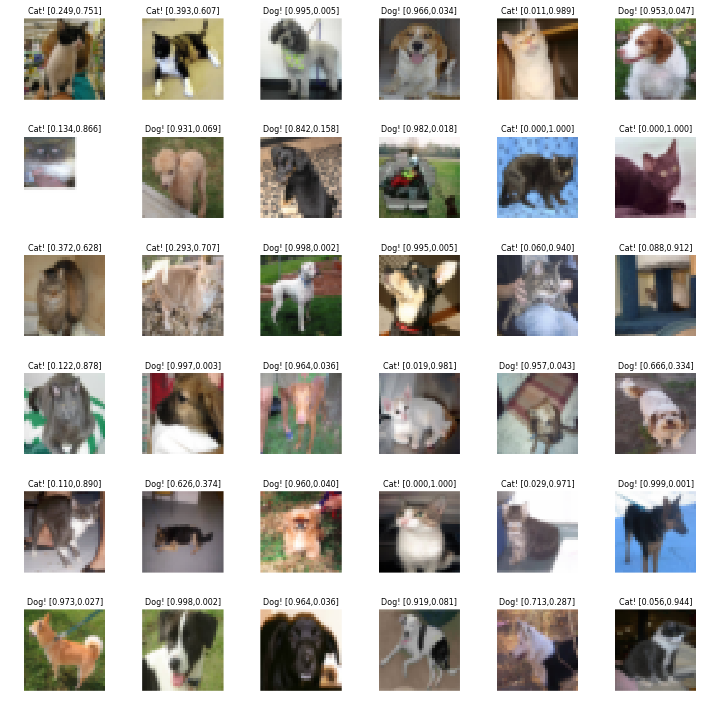

In [18]:
plt.figure(figsize=(10,10))
for i in range(36):
    # Randomly selects one image from our test set (same used for error calculation)
    idx = numpy.random.randint(0,testData.shape[0])
    X = testData[idx].reshape(1,testData[idx].shape[0]) # They are already normalised...
    Y = testLabels[idx]

    # [1.,0.]=>Dog
    # [0.,1.]=>Cat
    pred = model.predict(X)
    if pred[0,0]>pred[0,1]:
        title = "Dog! [{:.3f},{:.3f}]".format(pred[0,0],pred[0,1])
    else:
        title = "Cat! [{:.3f},{:.3f}]".format(pred[0,0],pred[0,1])

    # Visualization
    # But remember, the network was fed with the same data below reshaped as a 1D vector
    img = training_set[random_selection[:int(len(training_set)*(test_size))][idx]][-1].reshape((32,32,3))
    plt.subplot2grid((6,6),(i/6,i%6))
    plt.imshow(img,interpolation='none')
    plt.title(title, fontdict={'fontsize': 8})
    plt.axis('off')
plt.tight_layout()
plt.show()

## Testing using the test1 directory
### Images the neural network has never seen before
But first we need to load and prepare the images

In [19]:
# Returns the current working directory
# (where the Python interpreter was called)
path = os.getcwd()

# The path separator used by the OS:
sep = os.path.sep

# This is the directory where the training images are located
dirname = "test1"

# Generates a list of all images (actualy the filenames) from the training set,
# but it will also include the full path
imagePaths = [path+sep+dirname+sep+filename 
                  for filename in os.listdir(path+sep+dirname)]

In [20]:
%%time
ans = Pool(number_of_parallel_processes).map(import_training_set,[(i,img,new_image_size) 
                                                                  for i,img in enumerate(imagePaths)])

CPU times: user 134 ms, sys: 84.4 ms, total: 218 ms
Wall time: 21.8 s


In [21]:
testing_set = dict(ans)
del ans # this is just to help saving memory...

### Selects a random image

In [22]:
idx = numpy.random.randint(0,len(testing_set))
X = testing_set[idx][-1].reshape(1,testing_set[idx][-1].shape[0])/255.0 # /255.0=>normalisation!

In [23]:
# [1.,0.]=>Dog
# [0.,1.]=>Cat
pred = model.predict(X)
if pred[0,0]>pred[0,1]:
    print("Dog! [{},{}]".format(pred[0,0],pred[0,1]))
else:
    print("Cat! [{},{}]".format(pred[0,0],pred[0,1]))

Cat! [0.0523850880563,0.947614848614]


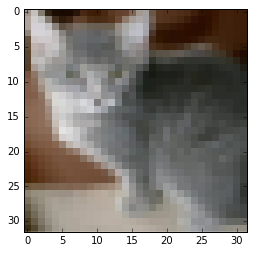

In [24]:
img = testing_set[idx][-1].reshape((32,32,3))
plt.imshow(img,interpolation='none')
plt.show()

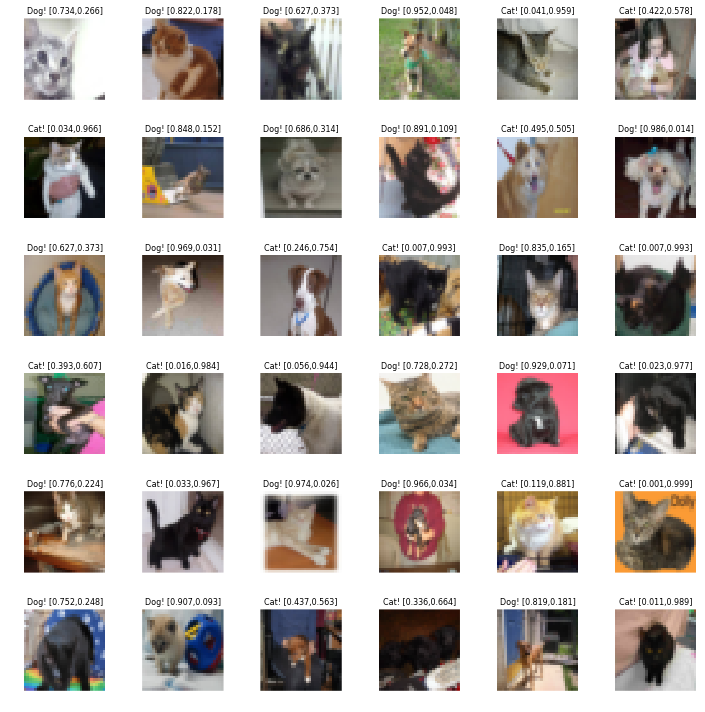

In [25]:
plt.figure(figsize=(10,10))
for i in range(36):
    # Randomly selects one image from our test set (same used for error calculation)
    idx = numpy.random.randint(0,len(testing_set))
    X = testing_set[idx][-1].reshape(1,testing_set[idx][-1].shape[0])/255.0 # /255.0=>normalisation!

    # [1.,0.]=>Dog
    # [0.,1.]=>Cat
    pred = model.predict(X)
    if pred[0,0]>pred[0,1]:
        title = "Dog! [{:.3f},{:.3f}]".format(pred[0,0],pred[0,1])
    else:
        title = "Cat! [{:.3f},{:.3f}]".format(pred[0,0],pred[0,1])

    # Visualization
    # But remember, the network 'eats' images reshaped as 1D vectors
    img = testing_set[idx][-1].reshape((32,32,3))
    plt.subplot2grid((6,6),(i/6,i%6))
    plt.imshow(img,interpolation='none')
    plt.title(title, fontdict={'fontsize': 8})
    plt.axis('off')
plt.tight_layout()
plt.show()

## Loading an image from a URL

In [26]:
def get_img_from_url(url):
    # http://stackoverflow.com/a/7391991
    file = cStringIO.StringIO(urllib.urlopen(url).read())
    return scipy.misc.imread(file)

In [27]:
dog_url = "https://cdn.pixabay.com/photo/2016/02/19/15/46/dog-1210559_960_720.jpg"
cat_url = "https://cdn.pixabay.com/photo/2014/03/29/09/17/cat-300572_960_720.jpg"

Dog! [0.999576866627,0.000423109595431]


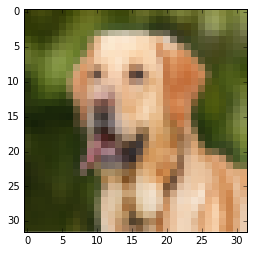

In [28]:
image = get_img_from_url(dog_url)

X = scipy.misc.imresize(image,(32,32)).flatten()/255.0 # /255.0=>normalisation!

# [1.,0.]=>Dog
# [0.,1.]=>Cat
pred = model.predict(X.reshape((1,X.shape[0])))
if pred[0,0]>pred[0,1]:
    print("Dog! [{},{}]".format(pred[0,0],pred[0,1]))
else:
    print("Cat! [{},{}]".format(pred[0,0],pred[0,1]))
    
img = X.reshape((32,32,3))
plt.imshow(img,interpolation='none')
plt.show()

Cat! [0.164391964674,0.835608005524]


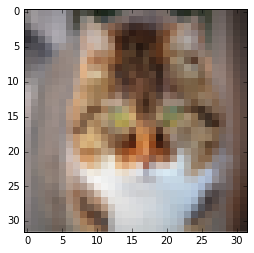

In [29]:
image = get_img_from_url(cat_url)

X = scipy.misc.imresize(image,(32,32)).flatten()/255.0 # /255.0=>normalisation!

# [1.,0.]=>Dog
# [0.,1.]=>Cat
pred = model.predict(X.reshape((1,X.shape[0])))
if pred[0,0]>pred[0,1]:
    print("Dog! [{},{}]".format(pred[0,0],pred[0,1]))
else:
    print("Cat! [{},{}]".format(pred[0,0],pred[0,1]))
    
img = X.reshape((32,32,3))
plt.imshow(img,interpolation='none')
plt.show()